# Let's get some free city data for Albuquerque, NM and make a heatmap of where in town most Breaking Bad filming took place

In [1]:
import geopandas as gp
from pathlib import Path
import fiona
fiona.drvsupport.supported_drivers['libkml'] = 'rw' # enable KML support which is disabled by default
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw' # enable KML support which is disabled by default


In [2]:
# data from https://www.cabq.gov/abq-data/

In [3]:
datapath = Path('./data/geopandas/abq/')

### here we have to do a bunch of data munging - this is always a big part of any data project

In [4]:
gdf = gp.read_file(datapath / 'abq_films.geojson')
gdf = gdf.loc[gdf.geometry != None] # there are some missing geometries, so we can skip those
gdf['Title'] = gdf['Title'].apply(lambda x:x.strip()) # let's strip off extra spaces from the Titles field
gdf.Title = ['In Plain Sight' if "Plain Sight" in i else i for i in gdf.Title]
gdf['Year'] = [i.year for i in gdf.ShootDate]
gdf = gdf.drop(columns='ShootDate') # something with this 

### what are the top 20 projects filming in ABQ?

<Axes: xlabel='Title'>

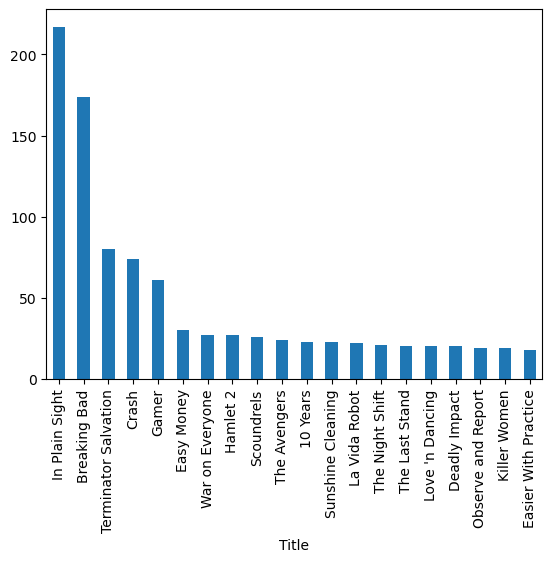

In [5]:
gdf.groupby('Title').count()['Type'].sort_values(ascending=False)[:20].plot.bar()

### we can just take a look at where Breaking Bad filming events took place as dots on the map

In [6]:
gdf.loc[gdf.Title=='Breaking Bad'].explore()

### What are the other titles?

In [7]:
gdf['Title'].unique()

array(['0000', '$5 a Day', '10 Years',
       '15 Good Reasons to go to Albuquerque', '2 Guns', '50 to 1',
       '500 MPH Storm', 'Adam Feldman',
       'Adventures of a Teenage Dragonslayer',
       'Albuquerque Convention and Visitors Bureau',
       'Albuquerque Economic Development', 'All in a Days Work',
       'All of Us', 'As Cool As I Am', 'Beyond the Blackboard',
       'Breaking Bad', 'Camera Obscura', 'Cineflix Productions',
       'CNM Student Film', 'Crash', 'Crazy Heart', 'Danappel Creative',
       'Dark Country', 'Dead Billy', 'Deadly Impact',
       'Desert Gems Productions', 'Desert Vamps 101',
       'Digital Filmmaking Institute', 'Doritos', 'Due Date',
       'Easier With Practice', 'Easy Money', 'Enemy Way',
       'Energy Advances New Mexico', 'Fatal Encounters',
       'Force of Execution', 'Frank', 'Friendship!', 'Frontera', 'Gamer',
       'Goats', 'Good Luck Mr Gorski', 'Great American Road Trip',
       'Habitat for Humanity', 'halflife digital', 'Hamlet 2'

In [8]:
gdf['Type'].unique()

array(['Movie', 'TV Production', 'Movie aka Hypercane', 'Political Ad',
       'Movie aka I was a 7th Grade Dragonslayer', 'Commercial',
       'Commercial by Production Outfitters',
       'Political Ad Martin Heinrich', 'Movie aka Let Them Shine',
       'TV Series Season 2', 'TV Series Season 3', 'TV Series Season 4',
       'TV Series Season 1', 'Movie Duke City Shootout ',
       'Movie CNM Student Film', 'TV Series Season 1 Episode 1',
       'TV Series Season 1 Episode 2', 'TV Series Season 1 Episode 3',
       'TV Series Season 1 Christian and Joe', 'Commercial for Kia',
       'Commercial for Transportation Security Administration',
       'Commercial by Marcia Woske', 'Commercial for Doritos',
       'TV Series', 'TV Series Wicked episode',
       'TV Series Road Warriors episode', 'PSA on DWI',
       'PSA on bicycle safety', 'Commercial for Hard Rock Casino',
       'TV Movie', 'TV Series Season 5', 'Movie by 9 Point Productions',
       'Video', 'TV Series by A& E', 'TV Sp

## read in the zone atlas - this is a grid from the city that is used for zoning, but we can use it as a base for a heatmap as it covers the city with equal-sized squares

In [9]:
gdf_pg = gp.read_file(datapath / 'zoneatlaspagegrid.kmz')
gdf_pg.explore()

### we can assign a variable `title_to_plot` to be able to check out heatmaps of any of the titles above

In [10]:
title_to_plot = 'Breaking Bad'

### Finally, we need to do a few things and set them to intermediate results:
- load a fresh copy of the polygons
- use `sjoin` to intersect the `gdf` points corresponding to the title named in `title_to_plot` which returns only the polygon of intersection for each point in the original point dataframe and convert to the correct CRS. Note that we can use only the columns we need (e.g. `[['Name','geometry']]) as long as `geometry` is included. This makes the results a little cleaner
- next, with that result, use `groupby` to count all the points based on their `Name` column
- count these up, choose a column from the result (we randomly chose `geometry` here) and rename the counts to a column called `points`
- finally merge the column of counts back to the original dataframe of zones noting that we will use `Name` on the left and `index` on the right

In [11]:
gdf_pg = gp.read_file(datapath / 'zoneatlaspagegrid.kmz') # load a fresh copy of the polygons 
gdf_pg.head(3)

,id,Name,description,timestamp,begin,end,altitudeMode,tessellate,extrude,visibility,drawOrder,icon,snippet,geometry
0,ID_00000,A1,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",NaT,NaT,NaT,clampToGround,-1,0,-1,NaN,None,,"MULTIPOLYGON Z (((-106.87033 35.21665 0, -106...."
1,ID_00001,A2,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",NaT,NaT,NaT,clampToGround,-1,0,-1,NaN,None,,"MULTIPOLYGON Z (((-106.85258 35.21674 0, -106...."
2,ID_00002,A3,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",NaT,NaT,NaT,clampToGround,-1,0,-1,NaN,None,,"MULTIPOLYGON Z (((-106.83482 35.21683 0, -106...."


use `sjoin` to intersect the `gdf` points corresponding to the title named in `title_to_plot` which returns only the polygon of intersection for each point in the original point dataframe and convert to the correct CRS. Note that we can use only the columns we need (e.g. `[['Name','geometry']]) as long as `geometry` is included. This makes the results a little cleaner. 

Note we print out the lengths of the starting and ending results for reference

In [12]:
sj_result = gdf_pg[['Name','geometry']].sjoin(
    gdf[['Title','geometry']].loc[gdf.Title==title_to_plot].to_crs(gdf_pg.crs))
print(len(sj_result), len(gdf.loc[gdf.Title==title_to_plot]), len(gdf_pg))
sj_result.head(3)

174 174 456


,Name,geometry,index_right,Title
12,A13,"MULTIPOLYGON Z (((-106.65731 35.21756 0, -106....",1370,Breaking Bad
60,C13,"MULTIPOLYGON Z (((-106.65716 35.18854 0, -106....",1378,Breaking Bad
64,C17,"MULTIPOLYGON Z (((-106.58618 35.18876 0, -106....",1375,Breaking Bad


Next, with that result, use `groupby` to count all the points based on their `Name` column.

This gives us counts for each column...

In [13]:
sj_count = sj_result.groupby(
    'Name').count()
print(len(sj_count))
sj_count.sample(4)

53


,geometry,index_right,Title
Name,,,
G21,2,2,2
Q14,2,2,2
F21,3,3,3
L20,1,1,1


Count these up, choose a column from the result (we randomly chose `geometry` here)

In [14]:
sj_sum = sj_count.geometry.rename('points')
sj_sum.head()

Name
A13    1
C13    1
C17    2
C19    1
D16    5
Name: points, dtype: int64

In [15]:
gdf_pg = gdf_pg[['Name','geometry']].merge(sj_sum, left_on='Name', right_index=True)

### Or, we can smack _all_ that work into a single chain (WAT!?)

In [16]:
gdf_pg = gp.read_file(datapath / 'zoneatlaspagegrid.kmz') # load a fresh copy of the polygons 
gdf_pg = gdf_pg.merge(gdf_pg[['Name','geometry']].sjoin(
    gdf[['Title','geometry']].loc[gdf.Title==title_to_plot].to_crs(gdf_pg.crs)).groupby(
    'Name').count().geometry.rename('points'), left_on='Name', right_index=True)

### finally, let's look at the result on the map overlaying the points with the heatmap. Whew!

In [17]:
m = gdf_pg[['points','geometry']].explore(column='points', cmap='magma_r')
gdf.loc[gdf.Title==title_to_plot][['Site', 'geometry']].explore(m=m)
